                timestamp      value
0     2013-07-04 00:00:00  69.880835
1     2013-07-04 01:00:00  71.220227
2     2013-07-04 02:00:00  70.877805
3     2013-07-04 03:00:00  68.959400
4     2013-07-04 04:00:00  69.283551
...                   ...        ...
7262  2014-05-28 11:00:00  72.370206
7263  2014-05-28 12:00:00  72.172956
7264  2014-05-28 13:00:00  72.046565
7265  2014-05-28 14:00:00  71.825226
7266  2014-05-28 15:00:00  72.584089

[7267 rows x 2 columns]
(7267, 2)


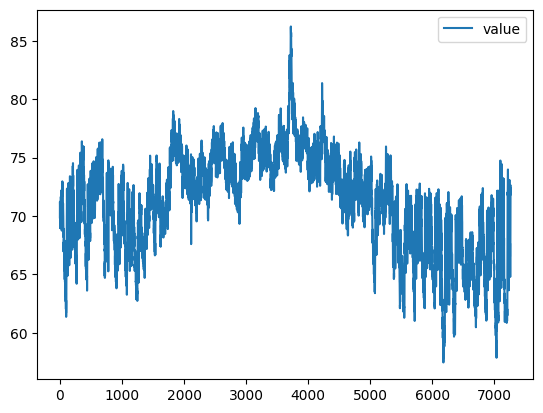

In [86]:
# Muestra los valores más anómalos del fichero csv suministrado
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Input
import joblib


# Cargar los datos (7267,1) (según el fichero cambiará el número de filas)
df = pd.read_csv("datos.csv",parse_dates=True)

print(df)
print(df.shape)

df.plot()
plt.show()

In [87]:
# Creo mis 2 dataFrames con ambas columnas y se crean las ventanas temporales
columnaDatos = df['value']
columnaFechas= df['timestamp']
nDatosVentana = 3
ventana = np.lib.stride_tricks.sliding_window_view(columnaDatos, window_shape=nDatosVentana)

ventana

array([[69.88083514, 71.22022706, 70.87780496],
       [71.22022706, 70.87780496, 68.95939994],
       [70.87780496, 68.95939994, 69.28355102],
       ...,
       [72.37020644, 72.17295622, 72.04656545],
       [72.17295622, 72.04656545, 71.82522648],
       [72.04656545, 71.82522648, 72.58408858]])

In [88]:
# Dividir los datos en entrenamiento y prueba es lo habitual
X = array(ventana[:-1])  # Todas las ventanas menos la última. Hay que convertir a array numpy
y = array(columnaDatos[nDatosVentana:])  # Lo que predices (el siguiente valor después de cada ventana)

porcentaje_entrenamiento = 0.7
nEntrenamiento = int(len(X) * porcentaje_entrenamiento)

X_train, X_test = X[:nEntrenamiento], X[nEntrenamiento:]
y_train, y_test = y[:nEntrenamiento], y[nEntrenamiento:]

# Redimensionar los datos para la RNN
# LSTM espera 3 dimensiones: número muestras, pasos temporales, número features
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

X_train
X_test

array([[[69.85636686],
        [70.50368788],
        [71.55722128]],

       [[70.50368788],
        [71.55722128],
        [72.2140082 ]],

       [[71.55722128],
        [72.2140082 ],
        [72.23486752]],

       ...,

       [[70.45571697],
        [72.37020644],
        [72.17295622]],

       [[72.37020644],
        [72.17295622],
        [72.04656545]],

       [[72.17295622],
        [72.04656545],
        [71.82522648]]])

In [89]:
# Crear la RNN
model = Sequential()
model.add(Input(shape=(nDatosVentana, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar la RNN
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test)) 

# Hacer predicciones sobre todo el conjunto
y_pred = model.predict(X)

#Aplano los datos de las predicciones y los transformo en un array de numpy para trabajar mejor con ellos
y_pred_trimmed = y_pred.flatten()
y_predArray = array(y_pred_trimmed)

y_predArray

Epoch 1/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3064.8479 - val_loss: 1.8827
Epoch 2/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 0.9309 - val_loss: 1.8763
Epoch 3/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.9265 - val_loss: 1.8540
Epoch 4/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - loss: 0.9536 - val_loss: 1.8370
Epoch 5/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.9123 - val_loss: 1.8263
Epoch 6/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.9168 - val_loss: 1.8042
Epoch 7/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 0.9399 - val_loss: 1.8059
Epoch 8/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 0.9266 - val_loss: 1.7612
Epoch 9/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.9625 - val_loss: 1.7427
Epoch 10/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.9284 - val_loss: 1.6988
Epoch 11/30
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 0.9050 - val_loss: 1.6750
Epoch 12/30
159/159 ━━━━━━━━━

array([70.70611 , 70.30272 , 69.49637 , ..., 71.731125, 72.09253 ,
       71.92158 ], dtype=float32)

In [90]:
# Calcular el error absoluto para cada predicción
errors = abs(y.flatten() - y_predArray.flatten())

# Calcular la media y la desviación estándar de los errores
mae = np.mean(errors)
std_error = np.std(errors)

# Establecer un umbral para las anomalías
threshold = mae + 2 * std_error  # Por ejemplo, 2 desviaciones estándar

#Imprimo por pantalla los valores
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Desviacion estandar: {std_error}")
print(f"Umbral: {threshold}")

Error Absoluto Medio (MAE): 0.7669293437557151
Desviacion estandar: 0.6161344885186921
Umbral: 1.9991983207930994


In [91]:
# Paso a array de numpy el dataTable de fechas para manipularlo mejor y creo un array de anomalias de booleanos
columnaFechas = array(columnaFechas[nDatosVentana:])
anomalies = []

In [92]:
#Creo mi array con las anomalias e imprimo por pantalla las anomalias y sus diferencias
for index in range(len(y_predArray)):
    if errors[index] > threshold:  # Verificamos si es una anomalia
        expected = y_predArray[index]  # Valor esperado
        received = y[index]     # Valor recibido
        difference = abs(received - expected)  # Diferencia
        print(f"Fecha: {columnaFechas[index]}, Esperado: {expected}, Recibido: {received}, Diferencia: {difference}")
        #plt.text(columnaFechas[index], y_predArray[index], f"{errors[index]:.2f}", color='red', fontsize=8, ha='right')
        anomalies.append(True)
    else:
       anomalies.append(False)

anomalies = np.array(anomalies)

#Resumen de las anomalias
print("El número de anomalías es " + str(np.sum(anomalies)) + " sobre " + str(df.shape[0]))

Fecha: 2013-07-05 11:00:00, Esperado: 69.88956451416016, Recibido: 72.53056283, Diferencia: 2.6409983158398376
Fecha: 2013-07-08 09:00:00, Esperado: 62.414649963378906, Recibido: 64.44813096, Diferencia: 2.033480996621094
Fecha: 2013-07-08 10:00:00, Esperado: 63.32634735107422, Recibido: 65.33294727, Diferencia: 2.0065999189257866
Fecha: 2013-07-08 11:00:00, Esperado: 64.41313934326172, Recibido: 66.51294379, Diferencia: 2.0998044467382755
Fecha: 2013-07-08 12:00:00, Esperado: 65.51753234863281, Recibido: 67.88554227, Diferencia: 2.3680099213671895
Fecha: 2013-07-08 16:00:00, Esperado: 68.00361633300781, Recibido: 70.32033392, Diferencia: 2.3167175869921834
Fecha: 2013-07-08 18:00:00, Esperado: 69.87055206298828, Recibido: 72.33830154, Diferencia: 2.467749477011722
Fecha: 2013-07-09 11:00:00, Esperado: 67.77684783935547, Recibido: 69.93367814, Diferencia: 2.156830300644529
Fecha: 2013-07-09 12:00:00, Esperado: 68.65612030029297, Recibido: 70.66856782, Diferencia: 2.012447519707038
Fech

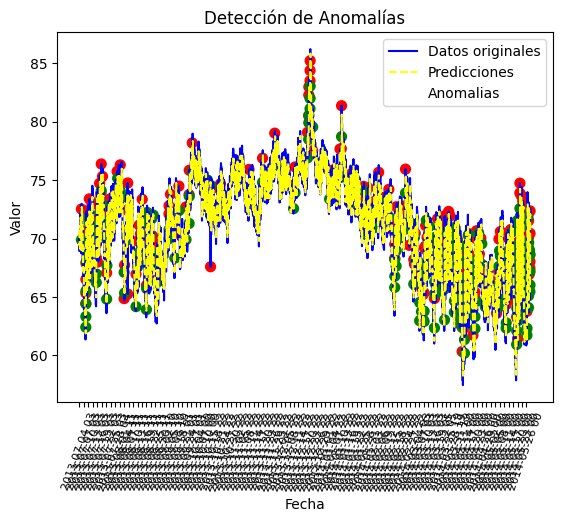

In [93]:
#Todas las funciones de matplotlab para mostrar la grafica de la manera que quiero hacera
#Muestro una linea azul con los valores reales, otras linea amarilla con las predicciones, y puntos rojos con las anomalias en los valores reales
#Y puntos verdes con las anomalias en las predicciones y el valor de la diferencia en los puntos rojos, ademas
#Divido las fechas cada 3 dias para no colapsar la grafica
plt.plot(columnaFechas, y, color='blue',label='Datos originales')
plt.plot(columnaFechas, y_predArray, color='yellow', linestyle='--', label='Predicciones')   # Añadir y_pred en color amarillo
plt.scatter(x=columnaFechas, y=y, c='red', alpha=anomalies.astype(int),s=50, label='Anomalias')
plt.scatter(x=columnaFechas, y=y_predArray, c='green', alpha=anomalies.astype(int),s=50)
plt.xlabel("Fecha")
plt.ylabel("Valor")
plt.title("Detección de Anomalías")

columnaFechas = pd.to_datetime(columnaFechas)
tick_positions = np.arange(0, len(columnaFechas), 72)  # Crear intervalos cada 72 puntos de datos
tick_labels = [date.strftime("%Y-%m-%d %H") for date in columnaFechas[tick_positions]]  # Formatear las fechas

plt.xticks(tick_positions, tick_labels, rotation=70, fontsize=8)

plt.legend()
plt.show()
